In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import Xception

c:\Users\gem_9\miniconda3\envs\dcp\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
base_model= Xception(include_top=False, weights="imagenet", input_shape=(256,256,3))

In [3]:
base_model.trainable = False
# for layer in base_model.layers:
#     layer.trainable = False

In [4]:

model= Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='softmax'))


In [5]:
data=pd.read_csv("HAM10000_metadata_kaggle.csv")
data.drop_duplicates(subset=['lesion_id'],inplace=True)
data['image_full_name']=data['image_id']+'.jpg'
X=data[['image_full_name','dx','lesion_id']]

In [6]:
from sklearn.model_selection import train_test_split
Y = X.pop('dx').to_frame()
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [7]:
train=pd.concat([X_train,y_train],axis=1)
val=pd.concat([X_val,y_val],axis=1)
test=pd.concat([X_test,y_test],axis=1)

In [8]:

from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx']) 
val['label']=name_as_indexes_train


In [9]:
encoder=LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx']) 
test['label']=name_as_indexes_test


In [10]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,  
                                     zoom_range = 0.1, 
                                     width_shift_range=0.0,  height_shift_range=0.0) 

In [11]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=64,directory="ISIC2018_Task3_Training_Input",
                                                shuffle=True,class_mode="categorical",target_size=(256,256))

Found 4482 validated image filenames belonging to 7 classes.


In [12]:

test_generator=ImageDataGenerator(rescale = 1./255)

In [13]:
test_data= test_generator.flow_from_dataframe(dataframe=test,x_col="image_full_name",y_col="dx",
                                              directory="ISIC2018_Task3_Training_Input",
                                              shuffle=False,batch_size=1,class_mode=None,target_size=(256,256))

Found 1494 validated image filenames.


In [14]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="ISIC2018_Task3_Training_Input",
                                            batch_size=64,shuffle=False,class_mode="categorical",target_size=(256,256))

Found 1494 validated image filenames belonging to 7 classes.


In [15]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=.5, min_lr=0.00001)
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='Xception.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=7, average='macro')])
history = model.fit_generator(generator=train_data,
                    steps_per_epoch=train_data.samples//train_data.batch_size,
                    validation_data=val_data,
                    verbose=1,
                    validation_steps=val_data.samples//val_data.batch_size,
                    epochs=50, callbacks=[learning_control, model_checkpoint])

C:\Users\gem_9\AppData\Local\Temp\ipykernel_9196\1796597191.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/50
70/70 [==============================] - ETA: 0s - loss: 1.0871 - accuracy: 0.6919 - precision: 0.8138 - recall: 0.5946 - f1_score: 0.1475
Epoch 1: val_accuracy improved from -inf to 0.74660, saving model to Xception.h5
70/70 [==============================] - 85s 1s/step - loss: 1.0871 - accuracy: 0.6919 - precision: 0.8138 - recall: 0.5946 - f1_score: 0.1475 - val_loss: 0.7319 - val_accuracy: 0.7466 - val_precision: 0.8653 - val_recall: 0.7072 - val_f1_score: 0.1287 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - ETA: 0s - loss: 0.8376 - accuracy: 0.7236 - precision: 0.8742 - recall: 0.6338 - f1_score: 0.1704
Epoch 2: val_accuracy improved from 0.74660 to 0.76291, saving model to Xception.h5
70/70 [==============================] - 74s 1s/step - loss: 0.8376 - accuracy: 0.7236 - precision: 0.8742 - recall: 0.6338 - f1_score: 0.1704 - val_loss: 0.7111 - val_accuracy: 0.7629 - val_precision: 0.9229 - val_recall: 0.6420 - val_f1_score: 0.1868 - lr: 0.0010
Epo

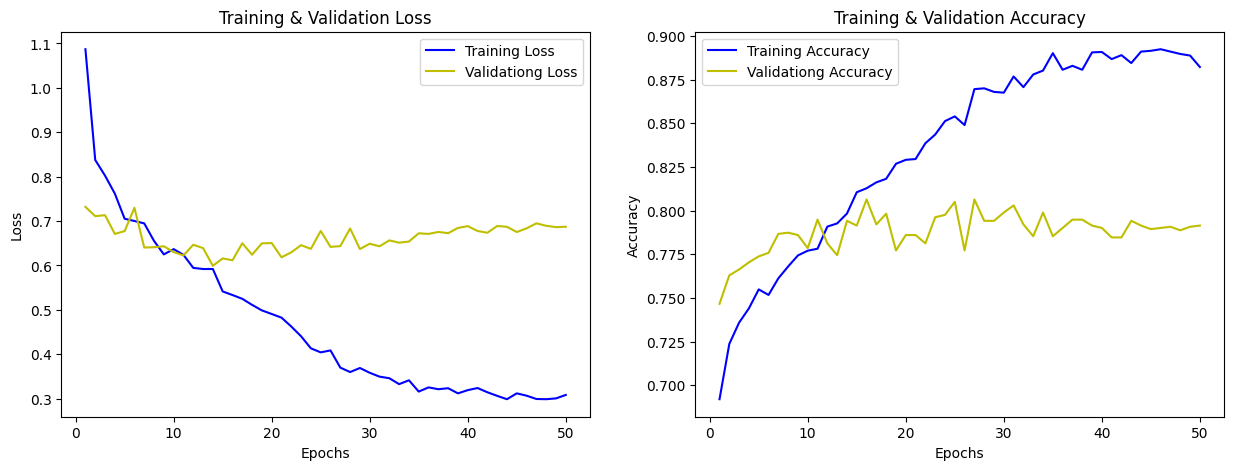

In [17]:
# Función para graficar la historia
import numpy as np
import matplotlib.pyplot as plt
EPOCAS = 50

def graficar(h):
    LOSS = 0
    ACCURACY = 1
    entrenamiento = np.zeros((2, EPOCAS))
    prueba = np.zeros((2, EPOCAS))
    entrenamiento[LOSS] = h.history['loss']  # loss de entrenamiento
    prueba[LOSS] = h.history['val_loss']    # loss de validación
    entrenamiento[ACCURACY] = h.history['accuracy']  # acc de entrenamiento
    prueba[ACCURACY] = h.history['val_accuracy']  # acc de validación
    epocas = range(1, EPOCAS+1)
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    for i, label in zip((LOSS, ACCURACY), ('Loss', 'Accuracy')):
        axs[i].plot(epocas, entrenamiento[i], 'b-', label='Training '+label)
        axs[i].plot(epocas, prueba[i], 'y-', label='Validationg '+label)
        axs[i].set_title('Training & Validation ' + label)
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(label)
        axs[i].legend()
    plt.show()

graficar(history)

In [18]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions, axis=1)

C:\Users\gem_9\AppData\Local\Temp\ipykernel_9196\1044357436.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)


1494/1494 [==============================] - 13s 8ms/step


In [19]:
from sklearn.metrics import confusion_matrix 
cm= confusion_matrix(name_as_indexes_test,y_pred)
print(cm)

[[ 14   7  11   0   6   9   0]
 [  3  37  20   0   8  16   0]
 [  3  10  82   0  21  39   0]
 [  1   3   4   0   1   9   0]
 [  1   4  11   0  47  57   0]
 [  1   4  19   0  26 997   0]
 [  0   2   3   0   0   8  10]]


In [20]:
print(name_as_indexes_test)

[5 2 5 ... 2 5 4]


In [21]:
from sklearn.metrics import classification_report
print(classification_report(name_as_indexes_test,y_pred))


              precision    recall  f1-score   support

           0       0.61      0.30      0.40        47
           1       0.55      0.44      0.49        84
           2       0.55      0.53      0.54       155
           3       0.00      0.00      0.00        18
           4       0.43      0.39      0.41       120
           5       0.88      0.95      0.91      1047
           6       1.00      0.43      0.61        23

    accuracy                           0.79      1494
   macro avg       0.57      0.44      0.48      1494
weighted avg       0.77      0.79      0.78      1494



c:\Users\gem_9\miniconda3\envs\dcp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gem_9\miniconda3\envs\dcp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gem_9\miniconda3\envs\dcp\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
